In [35]:
# Importación de librerías
import cv2
import numpy as np
import scipy.misc
from scipy.fftpack import dct
from scipy.fftpack import idct
#from scipy.fftpack import normalize
import pywt
from skimage.transform import pyramids, pyramid_gaussian, pyramid_laplacian
from matplotlib import pyplot as plt
from numba import jit
from os import listdir, path
import pyrtools as pt

In [36]:
# Agregar data set
image_dataset = []

ABSOLUTE_PATH = "D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PreprocesamientoImagenes/Contrast-Enhancer/images"
for img_path in listdir(ABSOLUTE_PATH):
    image_dataset.append(cv2.resize(cv2.imread(path.join(ABSOLUTE_PATH, img_path), 0), (256, 256)))

# Imprimir el número de imágenes en el dataset
print("Número de imágenes en el dataset: ", len(image_dataset))

Número de imágenes en el dataset:  11


Text(0.5, 1.0, 'Última imagen del dataset')

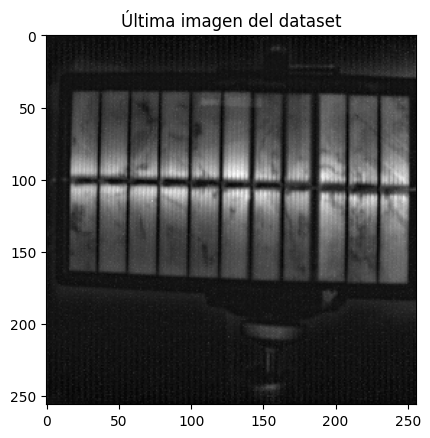

In [37]:
# Mostrar la primera imagen del dataset
plt.imshow(image_dataset[10], cmap='gray')
plt.title("Última imagen del dataset")

In [39]:
# Funciones que realizan operaciones sobre las imágenes

def normalize(img):
  """
  Normaliza una imagen.

  Parámetros:
    img: Imagen a normalizar.

  Retorno:
    Imagen normalizada con valores de píxeles en el rango [0, 255].
  """
  mx = np.amax(img)
  img /= mx
  img *= 255
  img = img.astype(np.uint8)
  return img

def dct2d(img):
  """
  Aplica la transformada discreta del coseno 2D a una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará la transformada.

  Retorno:
    Imagen en el dominio de la frecuencia.
  """
  img = img.astype(np.float32) / 255.0
  return dct(dct(img.T, norm='ortho').T, norm='ortho') * 255.0


def idct2d(img):
  """
  Aplica la transformada discreta del coseno inversa 2D a una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará la transformada inversa.

  Retorno:
    Imagen con la transformada inversa aplicada. Imagen en el 
    dominio del espacio, que es la inversa de la operación 
    realizada por dct2d(img).
  """
  img = img.astype(np.float32) / 255.0
  return idct(idct(img.T, norm='ortho').T, norm='ortho') * 255.0




A conotinuación se definen dos clases.
* La clase `Base` define la estructura básica y la función `apply_enhancement` para mejorar la imagen.
* La clase `DCTPyramidal` hereda de `Base` y implementa la transformada piramidal DCT sobre la imagen.

**Uso:**

* Crea una instancia de la clase `DCTPyramidal` con la imagen y el número de etapas deseados.
* Llama a la función `get_result()` para obtener la imagen transformada.

**Ejemplo:**

```python
img = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
dct_pyramid = DCTPyramidal(img, stage=3)
enhanced_img = dct_pyramid.get_result()
```

In [40]:
class Base(object):
  def __init__(self, img, stage=5):
    self.img = img
    self.result = None
    self.before_img_pyramid = []
    self.after_img_pyramid = []
    self.stage = stage

  def apply_enhancement(self, img):
      scaling_factor = 255.0 / img.max()
      hist_img = cv2.equalizeHist(np.uint8(img * scaling_factor)) / scaling_factor

      U, s, Vth = np.linalg.svd(img)
      Ul, sl, Vlth = np.linalg.svd(hist_img)

      E = np.max(sl) / np.max(s)
      alpha = (E + 1 / E) / 4
      S = alpha * ((E * s) + (sl / E))
      sigma = np.diag(S)

      enhanced_img = U @ sigma @ Vth
      return enhanced_img

  def transform(self, img):
    raise NotImplementedError("Este método debe ser implementado en la subclase.")

  def get_result(self):
    self.result = self.transform(self.img)

class DCTPyramidal(Base):
  def transform(self, img):
    if img.size == 1 or self.stage == 0:
      return img
    self.stage -= 1

    img_dct = dct2d(img)
    h, w = img_dct.shape

    LL = img_dct[:h // 2, :w // 2]
    img_LL = idct2d(LL)
    enhanced_img_LL = self.transform(img_LL)
    enhanced_img_LL_dct = dct2d(enhanced_img_LL)

    img_dct[:h // 2, :w // 2] = enhanced_img_LL_dct
    img = idct2d(img_dct)
    img = self.apply_enhancement(img)  # Reutilizar la función apply_enhancement
    return img


In [41]:
# Sobre-muestreo de una imagen
def upsample(img):
  """
  Realiza un sobre-muestreo de una imagen.

  Parámetros:
    img: Imagen a la que se le aplicará el sobre-muestreo.

  Retorno:
    Imagen con el sobre-muestreo aplicado.
  """
  return cv2.pyrUp(img, interpolation=cv2.INTER_LINEAR)


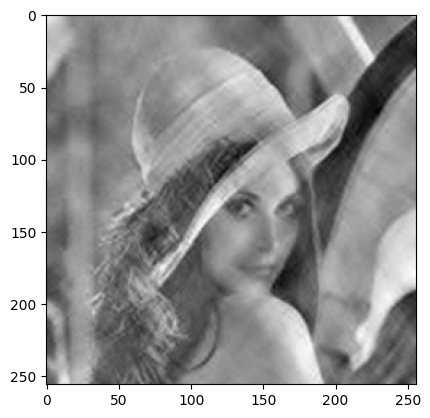

In [42]:
# Prueba de DCTPyramidal
lena_dark = image_dataset[0]
model = DCTPyramidal(lena_dark,stage=5)
model.get_result()
result = model.result
plt.imshow(result, cmap="gray")